---
title: House Prices: Advanced Regression Techniques
date: 2019-05-28
tags: [Kaggle]
categories: [Kaggle]
---

![替代文字](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

Kaggle Competition 的练习

[房价预测](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [0]:
# 安装 vecstack
!pip install vecstack

In [0]:
# 数据分析库
import pandas as pd
import numpy as np
import random

# 数据可视化
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 机器学习库
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold, train_test_split

# Ensemble Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Package for stacking models
from vecstack import stacking

# 导入数据

In [0]:
train = pd.read_csv('/train.csv', index_col='Id')
test = pd.read_csv('/test.csv', index_col='Id')

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 浏览数据

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [0]:
train.describe(include="O")

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


## 检查缺失数据

In [0]:
train_missing = train.isnull().sum()
train_missing = train_missing[train_missing > 0]
train_missing

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [0]:
test_missing = test.isnull().sum()
test_missing = test_missing[test_missing > 0]
test_missing

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [0]:
# 可视化缺失数据
def plot_missing(df):
    # 寻找缺失的列
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    
    # 画出缺失值的柱状图。
    missing.plot.bar(figsize=(10,8))
    plt.xlabel('Columns with missing values')
    plt.ylabel('Count')
    
    # 搜索缺失值
    import missingno as msno
    msno.matrix(df=df, figsize=(10,8))
    # 查看相关性
    #msno.heatmap(df=df,figsize=(10,8))

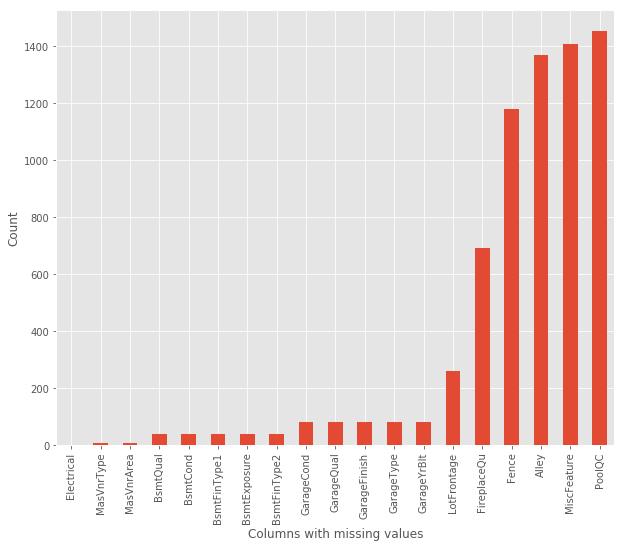

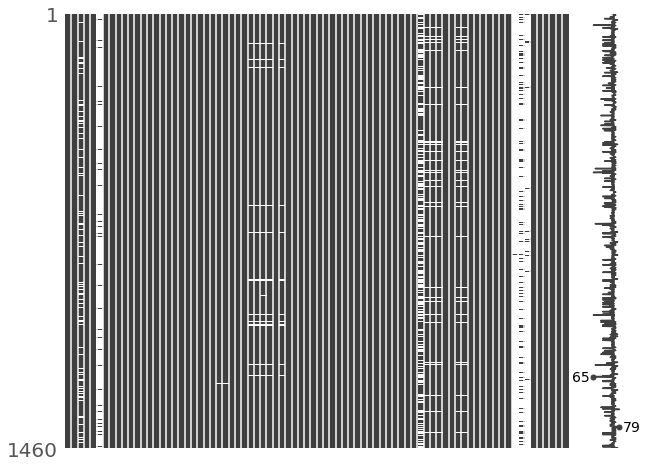

In [0]:
plot_missing(train)

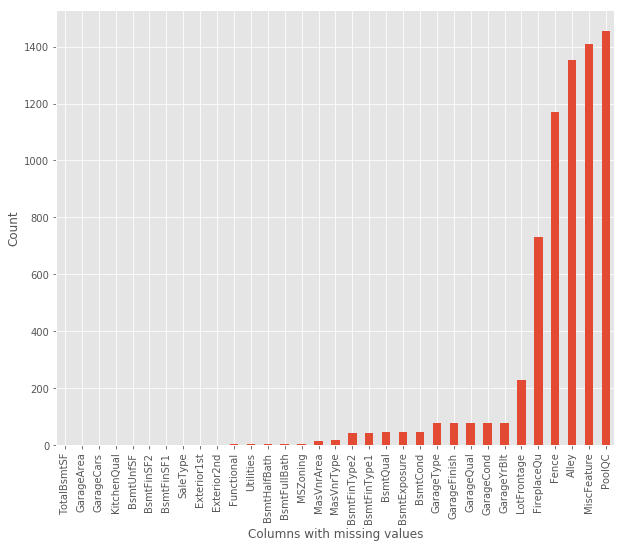

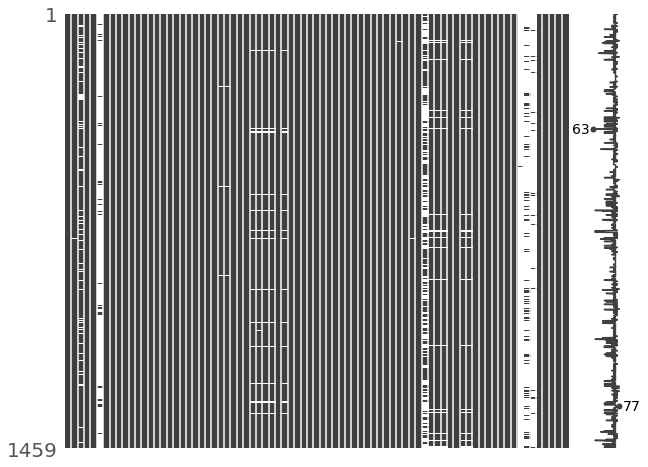

In [0]:
plot_missing(test)

# 分析概要

以下是缺失比较多的feature

Feature | Train miss | Test miss | Dispos 
:-: | :-: | :-: | :-: 
LotFrontage | 259 | 227 | 填个中位数吧
Alley | 1369 | 1352 |  删除 
FireplaceQu | 690 | 730 | fireplaceQU 和 fireplaces 有关 缺失项貌似都是没有fireplace的
PoolQC | 1453 | 1456 | 删除
Fence | 1179 | 1169 | 删除
MiscFeature | 1406 | 1408 | 删除

# 处理缺失值

In [0]:
# 删除缺失过多的feature
train = train.drop(['Alley', 'PoolQC', 'MiscFeature', 'Fence'], axis=1)
test = test.drop(['Alley', 'PoolQC', 'MiscFeature', 'Fence'], axis=1)

In [0]:
# FireplaceQu 缺失的都认为是没有的
train['FireplaceQu'] = train['FireplaceQu'].fillna('NA')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NA')

In [0]:
# 填充其他缺失值
def fill_missing_values(df):
    # 查找缺失值
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    for column in missing.index:
        # 类型为 object 的填众数
        if df[column].dtype == 'object':
            df[column].fillna(df[column].value_counts().index[0], inplace=True)
        # 其他类型填中位数
        else:
            df[column].fillna(df[column].median(), inplace=True)

In [0]:
fill_missing_values(train)
train.isnull().sum().max()

0

In [0]:
fill_missing_values(test)
test.isnull().sum().max()

0

好的，已经没有缺失数据了。

## 整理 description 文件

数据描述文件记录了所有特征所代表的含义，其中许多特征是字符串，现在我们要整理为个字典，便于我们查询。

In [0]:
description_dict = {}
with open('/data_description.txt','r') as description:
    description_data = description.read()
    description.close()
    
description_data = description_data.split('\n')

In [0]:
for i in description_data:
    if ':' in i:
        key = i.split(':')[0]
        description_dict[key] = []
    elif i.split() and '       ' in i:
        value = i.split()[0]
        description_dict[key].append(value)

print(description_dict)

{'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190'], 'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'], 'LotFrontage': [], 'LotArea': [], 'Street': ['Grvl', 'Pave'], 'Alley': ['Grvl', 'Pave', 'NA'], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'], 'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'], 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'], 'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'BldgType': ['1Fam', '2FmCo

## 字符串类型的 feature 重编码 

In [0]:
# 这个函数的作用是得到数据集中非数字的feature column
def get_object_column(df):
    object_column = []
    for column in df.columns:
        if df[column].dtype == 'object':
            object_column.append(column)
    return object_column

In [0]:
#object_column = get_object_column(train)

In [0]:
# 这个函数的作用是把 description_dict 中的 value 转换为对应数字的字典
def generate_map(map_list, end_index=1):
    d = {}
    j = len(map_list) - end_index
    for i in map_list:
        d[i] = j
        j -= 1
    return d

In [0]:
def preprocess_order_feature(df):
    for i in get_object_column(df):
        order_map = generate_map(description_dict[i], 0)
        df[i] = df[i].map(order_map)
        df[i] = df[i].fillna(0)
    return df

In [0]:
train = preprocess_order_feature(train)
test = preprocess_order_feature(test)

# 观察数据

In [0]:
train.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,2.825342,69.863699,10516.828082,1.004110,3.591781,3.814384,3.998630,4.583562,2.937671,10.747945,6.969178,6.993151,4.334247,0.497260,6.099315,5.575342,1971.267808,1984.865753,4.589726,6.924658,5.958904,5.271918,2.552740,103.117123,3.39589,3.083562,4.603425,4.565068,4.010959,2.656164,4.571233,443.639726,2.273288,46.549315,567.240411,1057.429452,4.963699,4.145205,1.065068,4.889726,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,3.511644,6.517808,7.841781,0.613014,2.825342,4.791781,1978.589041,2.771233,1.767123,472.980137,3.976712,3.975342,2.856164,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,9.509589,5.417808,180921.195890
std,42.300571,1.020174,22.027677,9981.264932,0.063996,0.582296,0.606509,0.052342,0.773448,0.276232,7.565716,0.878349,0.248272,1.555218,0.500164,1.382997,1.112799,30.202904,20.645407,0.834998,0.599127,4.426038,4.263353,1.046204,180.731373,0.57428,0.351054,0.722394,0.678071,0.284178,1.039123,2.070649,456.098091,0.869859,161.319273,441.866955,438.705324,0.295124,0.959501,0.246731,0.394658,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.663760,1.625393,0.667698,0.644666,1.810877,1.759864,23.997022,0.811835,0.747315,213.804841,0.241665,0.232860,0.496592,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,1.368616,1.475209,79442.502883
min,20.000000,0.000000,21.000000,1300.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.00000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,1.000000,2.000000,1900.000000,2.000000,0.000000,0.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,1.000000,1.000000,34900.000000
25%,20.000000,3.000000,60.000000,7553.500000,1.000000,3.000000,4.000000,4.000000,4.00

## 观察 feature 之间的相关性

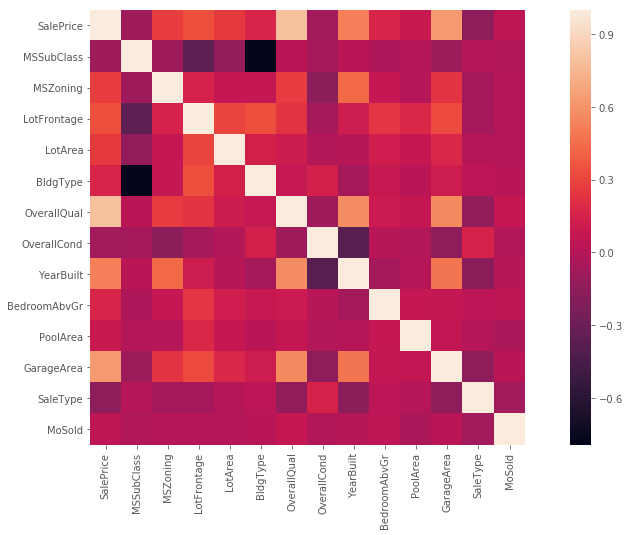

In [0]:
corr_mat = train[["SalePrice","MSSubClass","MSZoning","LotFrontage","LotArea", "BldgType",
                       "OverallQual", "OverallCond","YearBuilt", "BedroomAbvGr", "PoolArea", "GarageArea",
                       "SaleType", "MoSold"]].corr()
# corr_mat = train.corr()
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corr_mat, vmax=1 , square=True)

观察热力图，颜色越浅相关性越大。关于热力图-> [this video](https://www.youtube.com/watch?v=oMtDyOn2TCc).

## 观察年限和售价的规律

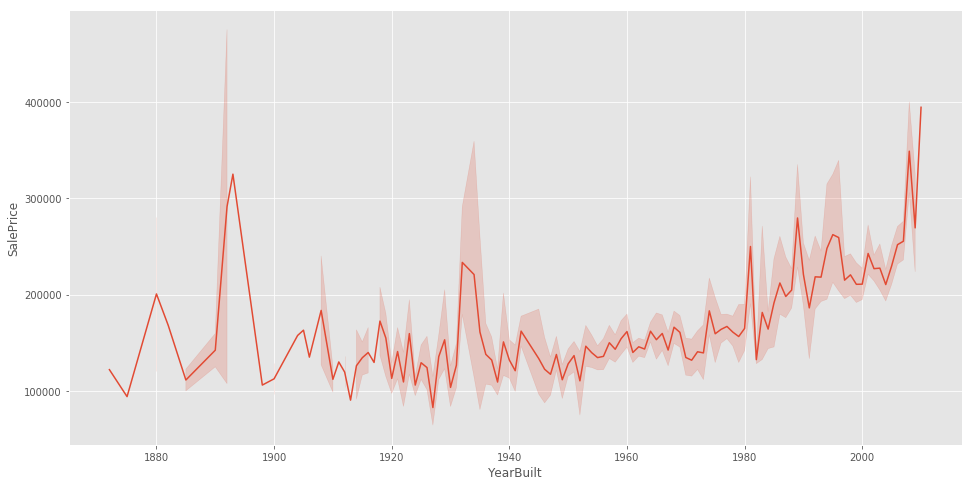

In [0]:
f, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='YearBuilt', y='SalePrice', data=train)

在二十世纪的时候价格增长迅速。

## 综合质量和售价有明显的相关性

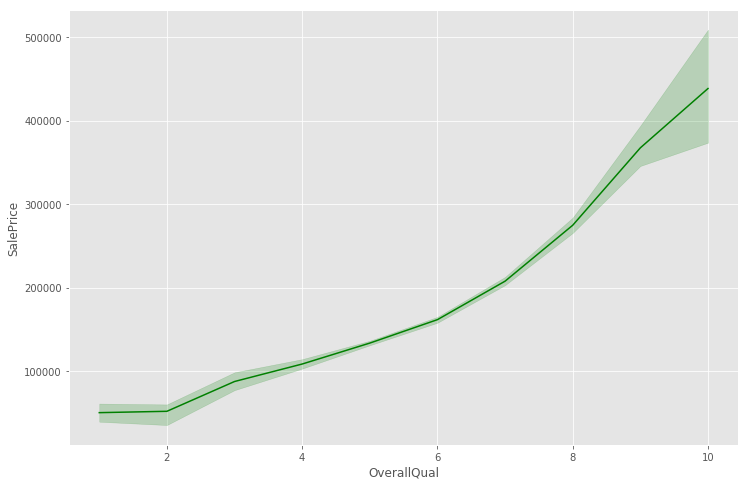

In [0]:
f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='OverallQual', y='SalePrice', color='green',data=train)

我们可以看到，随着房屋整体质量的提高，销售价格快速上涨，这是非常合理的。

## 观察售价

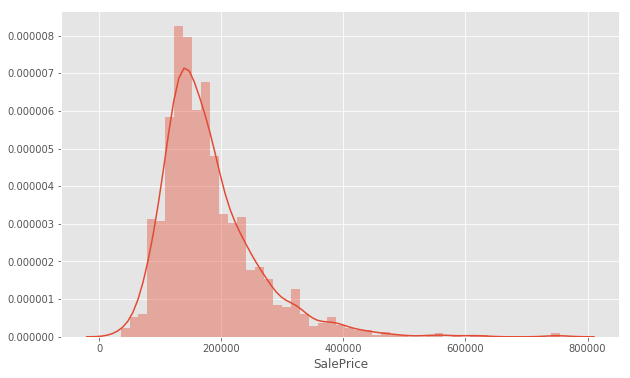

In [0]:
f, ax = plt.subplots(figsize=(10, 6))
sns.distplot(train['SalePrice'])

大部分的房屋售价在 100000 到  200000 之间。

# 构建预测模型

In [0]:
X = train.drop('SalePrice', axis=1)
y = np.ravel(np.array(train[['SalePrice']]))
print(y.shape)
y

(1460,)


array([208500, 181500, 223500, ..., 266500, 142125, 147500])

In [0]:
# Use train_test_split from sci-kit learn to segment our data into train and a local testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 定义评估函数

评估函数基于预测值的对数与观察到的销售价格的对数之间的均方根误差(RMSE)。

In [0]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

## 随机森林

In [0]:
random_forest = RandomForestRegressor(n_estimators=1200,
                                      max_depth=15,
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      max_features=None,
                                      random_state=42,
                                      oob_score=True)
kf = KFold(n_splits=5)
y_pred = cross_val_score(random_forest, X, y, cv=kf)
y_pred.mean()

0.8500001566166802

In [0]:
random_forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1200,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
rf_pred = random_forest.predict(test)

In [0]:
rf_pred

array([126945.71699684, 153924.56961003, 182182.80294353, ...,
       156066.28489667, 117296.65091637, 224995.13115853])

## XG Boost

In [0]:
xg_boost = XGBRegressor(learning_rate=0.01,
                        n_estimators=6000,
                        max_depth=4, 
                        min_child_weight=1,
                        gamma=0.6,
                        subsample=0.7,
                        colsample_bytree=0.2,
                        objective='reg:linear',
                        nthread=-1,
                        scale_pos_weight=1,
                        seed=27,
                        reg_alpha=0.00006)

kf = KFold(n_splits=5)
y_pred = cross_val_score(xg_boost, X, y, cv=kf)
y_pred.mean()

[03:11:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:11:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8959027545454475

In [0]:
xg_boost.fit(X, y)

[03:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0.6,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=6000,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.7, verbosity=1)

In [0]:
xgb_pred = xg_boost.predict(test)
xgb_pred

array([127263.77 , 163056.02 , 193208.25 , ..., 173218.75 , 115712.914,
       211616.88 ], dtype=float32)

## Gradient Boost Regressor(GBM)

In [0]:
g_boost = GradientBoostingRegressor(n_estimators=6000,
                                    learning_rate=0.01,
                                    max_depth=5,
                                    max_features='sqrt',
                                    min_samples_leaf=15,
                                    min_samples_split=10,
                                    loss='ls',
                                    random_state=42
                                    )

kf = KFold(n_splits=5)
y_pred = cross_val_score(g_boost, X, y, cv=kf)
y_pred.mean()

0.8905525972502479

In [0]:
g_boost.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=5,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=6000,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
gbm_pred = g_boost.predict(test)
gbm_pred

array([125909.87154943, 163184.8652622 , 187872.72372976, ...,
       176429.22616544, 119620.23912638, 211953.00041747])

## Light GBM

In [0]:
lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=6,
                         learning_rate=0.01,
                         n_estimators=6400,
                         verbose=-1,
                         bagging_fraction=0.8,
                         bagging_freq=4,
                         bagging_seed=6,
                         feature_fraction=0.2,
                         feature_fraction_seed=7
                         )
kf = KFold(n_splits=5)
y_pred = cross_val_score(lightgbm, X, y, cv=kf)
y_pred.mean()

0.8881867437856128

In [0]:
lightgbm.fit(X,y)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=4, bagging_seed=6,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2, feature_fraction_seed=7,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=6400, n_jobs=-1, num_leaves=6,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [0]:
lgb_pred = lightgbm.predict(test)
lgb_pred

array([124759.4703253 , 161206.70919126, 187680.444818  , ...,
       168310.83365532, 123698.90457326, 206480.92047866])

## Logistic Regression

In [0]:
logreg = LogisticRegression()
kf = KFold(n_splits=5)
y_pred = cross_val_score(logreg, X, y, cv=kf)
y_pred.mean()

In [0]:
logreg.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
round(logreg.score(X, y) * 100, 2)

88.9

In [0]:
log_pred = logreg.predict(test)
log_pred

array([135500, 128950, 175000, ..., 133900, 190000, 187500])

# 模型的叠加

叠加(也称为元集成)是一种模型集成技术，用于组合来自多个预测模型的信息，生成性能更好的新模型。在这个项目中，我们使用名为vecstack的python包，它可以帮助我们对前面导入的模型进行堆栈。它实际上非常容易使用，可以查看文档了解更多信息。[vecstack](https://github.com/vecxoz/vecstack)

In [0]:
models = [g_boost, xg_boost, lightgbm, random_forest]

In [0]:
Strain, S_test = stacking(models,
                          X_train,
                          y_train,
                          X_test,
                          regression=True,
                          mode='oof_pred_bag',
                          metric=rmse,
                          n_folds=5,
                          random_state=25,
                          verbose=2)

task:         [regression]
metric:       [rmse]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [GradientBoostingRegressor]
    fold  0:  [0.12653004]
    fold  1:  [0.13818165]
    fold  2:  [0.10747644]
    fold  3:  [0.14980732]
    fold  4:  [0.11127270]
    ----
    MEAN:     [0.12665363] + [0.01595833]
    FULL:     [0.12764756]

model  1:     [XGBRegressor]
[03:23:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [0.11631560]
[03:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [0.14701253]
[03:24:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  2:  [0.10450330]
[03:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  3:  [0.14328067]
[03

In [0]:
Strain, S_test

(array([[145154.57609501, 140247.640625  , 144708.92814448,
         136304.80002144],
        [441586.84575012, 453786.875     , 476049.8262998 ,
         433615.5690085 ],
        [205559.38156983, 199459.953125  , 204548.62741617,
         189012.87710637],
        ...,
        [229773.83814053, 245324.03125   , 222988.34529258,
         233726.54189435],
        [ 78529.68615301,  81706.46875   ,  74919.86211206,
          94651.91862458],
        [126564.42955093, 118016.921875  , 131591.97464745,
         134449.34870648]]),
 array([[156946.11019358, 162235.903125  , 156274.58204718,
         174271.19166786],
        [168719.74644755, 171368.26875   , 172660.15892698,
         168988.4858204 ],
        [165875.73697659, 167827.703125  , 166511.09786993,
         144720.7621456 ],
        ...,
        [235105.18179731, 240780.803125  , 236012.18528746,
         224310.44197611],
        [311340.99357469, 306275.29375   , 305036.50098821,
         319953.95931372],
        [100400

In [0]:
# Initialize 2nd level model
xgb_lev2 = XGBRegressor(learning_rate=0.1, 
                        n_estimators=500,
                        max_depth=3,
                        n_jobs=-1,
                        random_state=17
                       )

# Fit the 2nd level model on the output of level 1
xgb_lev2.fit(Strain, y_train)

[03:25:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=17,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
# Make predictions on the localized test set
stacked_pred = xgb_lev2.predict(S_test)
print("RMSE of Stacked Model: {}".format(rmse(y_test,stacked_pred)))

RMSE of Stacked Model: 0.12290530277450722


In [0]:
y1_pred_L1 = models[0].predict(test)
y2_pred_L1 = models[1].predict(test)
y3_pred_L1 = models[2].predict(test)
y4_pred_L1 = models[3].predict(test)
S_test_L1 = np.c_[y1_pred_L1, y2_pred_L1, y3_pred_L1, y4_pred_L1]

In [0]:
test_stacked_pred = xgb_lev2.predict(S_test_L1)

In [0]:
# Save the predictions in form of a dataframe
submission = pd.DataFrame()

submission['Id'] = np.array(test.index)
submission['SalePrice'] = test_stacked_pred

In [0]:
submission.to_csv('/submissionV2.csv', index=False)

# 混合较好得分的 submission

因为不知道最终的测试集合的正真数据是什么，只能一遍一遍提交去蒙，看到别人的方法是混合他人较好的提交去验证，尝试下看看。

In [0]:
submission_v1 = pd.read_csv('/House_price_submission_v44.csv')
submission_v2 = pd.read_csv('/submissionV19.csv')
submission_v3 = pd.read_csv('/blended_submission.csv')

In [0]:
final_blend = 0.5*submission_v1.SalePrice.values + 0.2*submission_v2.SalePrice.values + 0.3*submission_v3.SalePrice.values

blended_submission = pd.DataFrame()

blended_submission['Id'] = submission_v1.Id.values
blended_submission['SalePrice'] = final_blend

In [0]:
blended_submission.to_csv('/submissionV20.csv', index=False)
blended_submission

![替代文字](https://drive.google.com/open?id=15_Fut7y-MfkcSx2tOWvR5J57qpQ52iuT)


呃，就这样吧，最终和前十名差不到0.004。

# 用 Tensorfolw 试试

In [0]:
import math
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
correlation_dataframe = train.copy()
saleprice_corr = correlation_dataframe.corr()['SalePrice']
saleprice_corr = saleprice_corr[saleprice_corr > 0]
corr_feature = saleprice_corr.index

In [0]:
corr_feature

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Utilities', 'BldgType',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MoSold', 'SalePrice'],
      dtype='object')

In [0]:
def preprocess_feature(df, corr_feature):
    newdf = pd.DataFrame()
    for feature in corr_feature:
        newdf[feature] = df[feature]
    return newdf

In [0]:
X = preprocess_feature(train, corr_feature).drop('SalePrice', axis=1)
y = np.ravel(np.array(train[['SalePrice']]))

In [0]:
X.describe()

,MSZoning,LotFrontage,LotArea,Utilities,BldgType,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MoSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2.825342,69.863699,10516.828082,3.998630,4.334247,6.099315,1971.267808,1984.865753,2.552740,103.117123,3.39589,3.083562,4.565068,4.010959,2.656164,4.571233,443.639726,567.240411,1057.429452,4.963699,4.145205,4.889726,1162.626712,346.992466,1515.463699,0.425342,1.565068,0.382877,2.866438,3.511644,6.517808,7.841781,0.613014,2.825342,4.791781,1978.589041,2.771233,1.767123,472.980137,3.976712,3.975342,2.856164,94.244521,46.660274,3.409589,15.060959,2.758904,6.321918
std,1.020174,22.027677,9981.264932,0.052342,1.555218,1.382997,30.202904,20.645407,1.046204,180.731373,0.57428,0.351054,0.678071,0.284178,1.039123,2.070649,456.098091,441.866955,438.705324,0.295124,0.959501,0.394658,386.587738,436.528436,525.480383,0.518911,0.550916,0.502885,0.815778,0.663760,1.625393,0.667698,0.644666,1.810877,1.759864,23.997022,0.811835,0.747315,213.804841,0.241665,0.232860,0.496592,125.338794,66.256028,29.317331,55.757415,40.177307,2.703626
min,0.000000,21.000000,1300.000000,2.000000,0.000000,1.000000,1872.000000,1950.000000,1.000000,0.000000,2.00000,1.000000,3.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,1.000000,2.000000,1900.000000,2.000000,0.000000,0.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,60.000000,7553.500000,4.000000,5.000000,5.000000,1954.000000,1967.000000,2.000000,0.000000,3.00000,3.000000,4.000000,4.000000,2.000000,2.000000,0.000000,223.000000,795.750000,5.000000,3.000000,5.000000,882.000000,0.000000,1129.500000,0.000000,1.000000,0.000000,2.000000,3.000000,5.000000,8.000000,0.000000,1.000000,2.000000,1962.000000,2.000000,1.000000,334.500000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,3.000000,69.000000,9478.500000,4.000000,5.000000,6.000000,1973.000000,1994.000000,2.000000,0.000000,3.00000,3.000000,5.000000,4.000000,2.000000,5.000000,383.500000,477.500000,991.500000,5.000000,5.000000,5.000000,1087.000000,0.000000,1464.000000,0.000000,2.000000,0.000000,3.000000,3.000000,6.000000,8.000000,1.000000,3.000000,6.000000,1980.000000,3.000000,2.000000,480.000000,4.000000,4.000000,3.000000,0.000000,25.000000,0.000000,0.000000,0.000000,6.000000
75%,3.000000,79.000000,11601.500000,4.000000,5.000000,7.000000,2000.000000,2004.000000,4.000000,164.250000,4.00000,3.000000,5.000000,4.000000,3.000000,7.000000,712.250000,808.000000,1298.250000,5.000000,5.000000,5.000000,1391.250000,728.000000,1776.750000,1.000000,2.000000,1.000000,3.000000,4.000000,7.000000,8.000000,1.000000,5.000000,6.000000,2001.000000,3.000000,2.000000,576.000000,4.000000,4.000000,3.000000,168.000000,68.000000,0.000000,0.000000,0.000000,8.000000
max,6.000000,313.000000,215245.000000,4.000000,5.000000,10.000000,2010.000000,2010.000000,5.000000,1600.000000,5.00000,5.00

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def construct_feature_columns(input_features):
    """构造TensorFlow特征列
        参数:
            input_features:要使用的数字输入特性的名称。
        返回:
            一个 feature columns 集合
    """
    return set([tf.feature_column.numeric_column(my_feature) 
                for my_feature in input_features])

In [0]:
def train_model(
    learning_rate,
    strps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """训练多元特征的线性回归模型
        除训练外，此功能还打印训练进度信息，
        以及随着时间的推移而失去的训练和验证。
    参数:
        learning_rate:一个float，表示学习率
        steps:一个非零的int，训练步骤的总数。训练步骤
            由使用单个批处理的向前和向后传递组成。
        batch_size:一个非零的int
        training_example: DataFrame 包含一个或多个列
        '  california_housing_dataframe '作为训练的输入feature
        training_targets:一个' DataFrame '，它只包含一列
        ' california_housing_dataframe '作为训练的目标。
        validation_example: ' DataFrame '包含一个或多个列
        ' california_housing_dataframe '作为验证的输入feature
        validation_targets: ' DataFrame '，仅包含来自其中的一列
        ' california_housing_dataframe '作为验证的目标。
    返回:
        在训练数据上训练的“线性回归器”对象
    """
    periods = 10
    steps_per_period = strps / periods
    
    # 创建一个线性回归对象
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(
        training_examples,
        training_targets,
        batch_size=batch_size)
    
    predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets, 
      num_epochs=1, 
      shuffle=False)
    
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, 
        validation_targets,
        num_epochs=1,
        shuffle=False)
    
    #训练模型，但要在循环中进行，这样我们才能定期评估
    #损失指标
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
      # Train the model, starting from the prior state.
      linear_regressor.train(
          input_fn=training_input_fn,
          steps=steps_per_period,
      )
      # Take a break and compute predictions.
      training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
      training_predictions = np.array([item['predictions'][0] for item in training_predictions])
      
      validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
      validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
      

      # Compute training and validation loss.
      training_root_mean_squared_error = math.sqrt(
          metrics.mean_squared_error(training_predictions, training_targets))
      validation_root_mean_squared_error = math.sqrt(
          metrics.mean_squared_error(validation_predictions, validation_targets))
      # Occasionally print the current loss.
      print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
      # Add the loss metrics from this period to our list.
      training_rmse.append(training_root_mean_squared_error)
      validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 115236.06
  period 01 : 135729.29
  period 02 : 94007.13
  period 03 : 94940.56
  period 04 : 78776.40
  period 05 : 73407.86
  period 06 : 79100.02
  period 07 : 76995.32
  period 08 : 94657.55
  period 09 : 55721.83
Model training finished.


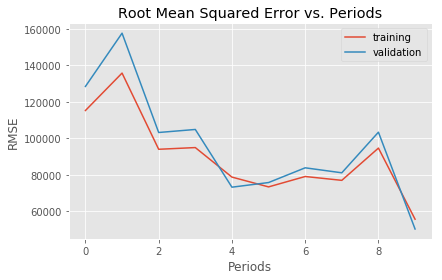

In [0]:
linear_regressor = train_model(
    learning_rate=0.5,
    strps=200,
    batch_size=5,
    training_examples=X_train,
    training_targets=y_train,
    validation_examples=X_test,
    validation_targets=y_test)


Training model...
RMSE (on training data):
  period 00 : 126663.18
  period 01 : 89900.76
  period 02 : 67300.53
  period 03 : 73597.13
  period 04 : 59429.95
  period 05 : 60645.34
  period 06 : 57056.42
  period 07 : 55974.51
  period 08 : 59490.64
  period 09 : 59963.44
Model training finished.


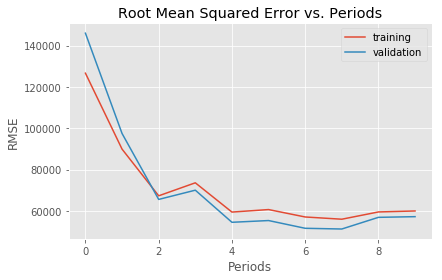

In [0]:
linear_regressor2 = train_model(
    learning_rate=0.25,
    strps=500,
    batch_size=5,
    training_examples=X_train,
    training_targets=y_train,
    validation_examples=X_test,
    validation_targets=y_test)

In [0]:
predict_test_input_fn = lambda: my_input_fn(
      test, 
      test, 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
test_predictions

array([152403.8 , 178793.02, 186845.23, ..., 203018.39, 142496.02,
       197809.12], dtype=float32)

就先这样吧。